In [1]:
!wget "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
from helper_functions import plot_loss_curves

--2022-11-16 08:23:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.4’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-11-16 08:23:19 (67.7 MB/s) - ‘helper_functions.py.4’ saved [10246/10246]



In [2]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support

def calculate_results(y_true,y_pred):
  model_accuracy = accuracy_score(y_true,y_pred)*100
  model_precision,model_recall,model_f1,_ = precision_recall_fscore_support(y_true,y_pred,
                                                                            average = "weighted")
  model_results = {"accuracy":model_accuracy,
                   "precision":model_precision*100,
                   "recall":model_recall*100,
                   "f1":model_f1*100}

  return model_results

In [3]:
import pandas as pd
all_data_df = pd.read_csv("/content/sms_spam.csv")

In [4]:
new_df_layer = []
for elem in all_data_df["type"]:
  if elem=="ham":
    new_df_layer.append(0)
  else:
    new_df_layer.append(1)
  
all_data_df["newType"] = new_df_layer

In [5]:
all_data_df

,type,text,newType
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...,1
5570,ham,Will ü b going to esplanade fr home?,0
5571,ham,"Pity, * was in mood for that. So...any other s...",0
5572,ham,The guy did some bitching but I acted like i'd...,0


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(all_data_df["text"].to_numpy(),
                                                                            all_data_df["newType"].to_numpy(),
                                                                            test_size = 0.1,
                                                                            random_state=42)

In [8]:
length = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

In [9]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = 15000,
                                    standardize = None,
                                    split = "whitespace",
                                    ngrams = 2,
                                    output_mode = "int",
                                    output_sequence_length = length,
                                    pad_to_max_tokens=False)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model0 = Pipeline([
                  ("tfidf",TfidfVectorizer()),
                  ("clf",MultinomialNB())
])

model0.fit(train_sentences,
           train_labels)

baseline_preds = model0.predict(val_sentences)
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)

baseline_results

{'accuracy': 96.05734767025089,
 'precision': 96.23082437275986,
 'recall': 96.05734767025089,
 'f1': 95.78742304200276}

In [11]:
import tensorflow as tf
import tensorflow_hub as hub

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape = [],
                                        dtype = tf.string,
                                        name="USE")

In [12]:
import tensorflow.keras.layers as layers
model = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(1,activation="sigmoid"),
])

model.compile(loss="binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              metrics = ["accuracy"])

In [13]:
history = model.fit(train_sentences,
          train_labels,
          epochs = 10,
          validation_data = (val_sentences, val_labels))

Epoch 1/10
157/157 [==============================] - 10s 22ms/step - loss: 0.1934 - accuracy: 0.9370 - val_loss: 0.0352 - val_accuracy: 0.9892
Epoch 2/10
157/157 [==============================] - 2s 15ms/step - loss: 0.0410 - accuracy: 0.9874 - val_loss: 0.0386 - val_accuracy: 0.9839
Epoch 3/10
157/157 [==============================] - 2s 15ms/step - loss: 0.0227 - accuracy: 0.9940 - val_loss: 0.0380 - val_accuracy: 0.9875
Epoch 4/10
157/157 [==============================] - 2s 15ms/step - loss: 0.0144 - accuracy: 0.9962 - val_loss: 0.0357 - val_accuracy: 0.9875
Epoch 5/10
157/157 [==============================] - 2s 15ms/step - loss: 0.0094 - accuracy: 0.9978 - val_loss: 0.0441 - val_accuracy: 0.9839
Epoch 6/10
157/157 [==============================] - 2s 14ms/step - loss: 0.0048 - accuracy: 0.9992 - val_loss: 0.0478 - val_accuracy: 0.9857
Epoch 7/10
157/157 [==============================] - 2s 14ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0461 - val_accuracy: 0.989

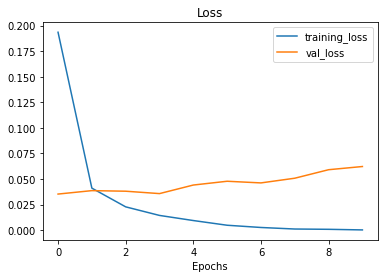

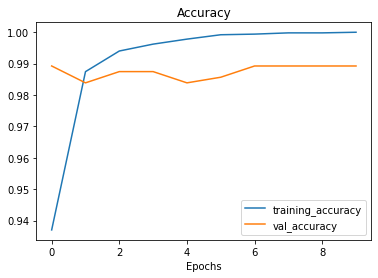

In [14]:
plot_loss_curves(history)

In [15]:
model_pred_probs = model.predict(val_sentences)
model_preds = tf.squeeze(tf.round(model_pred_probs))
model_results = calculate_results(y_true = val_labels,
                                  y_pred = model_preds)
model_results

18/18 [==============================] - 1s 12ms/step


{'accuracy': 98.9247311827957,
 'precision': 98.9185277088503,
 'recall': 98.9247311827957,
 'f1': 98.91904809399146}